In [ ]:
! pip install pandas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ds=pd.read_csv('/content/gold_monthly_csv.csv')

In [ ]:
ds.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [ ]:
ds.shape

(847, 2)

In [ ]:
print(f"Date range of prices from -{ds.loc[:,'Date'][0]} to {ds.loc[:,'Date'][len(ds)-1]}")

Date range of prices from -1950-01 to 2020-07


In [ ]:
date=pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [ ]:
ds['month']=date
ds.drop('Date', axis=1, inplace=True)
ds=ds.set_index('month')

In [ ]:
ds.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


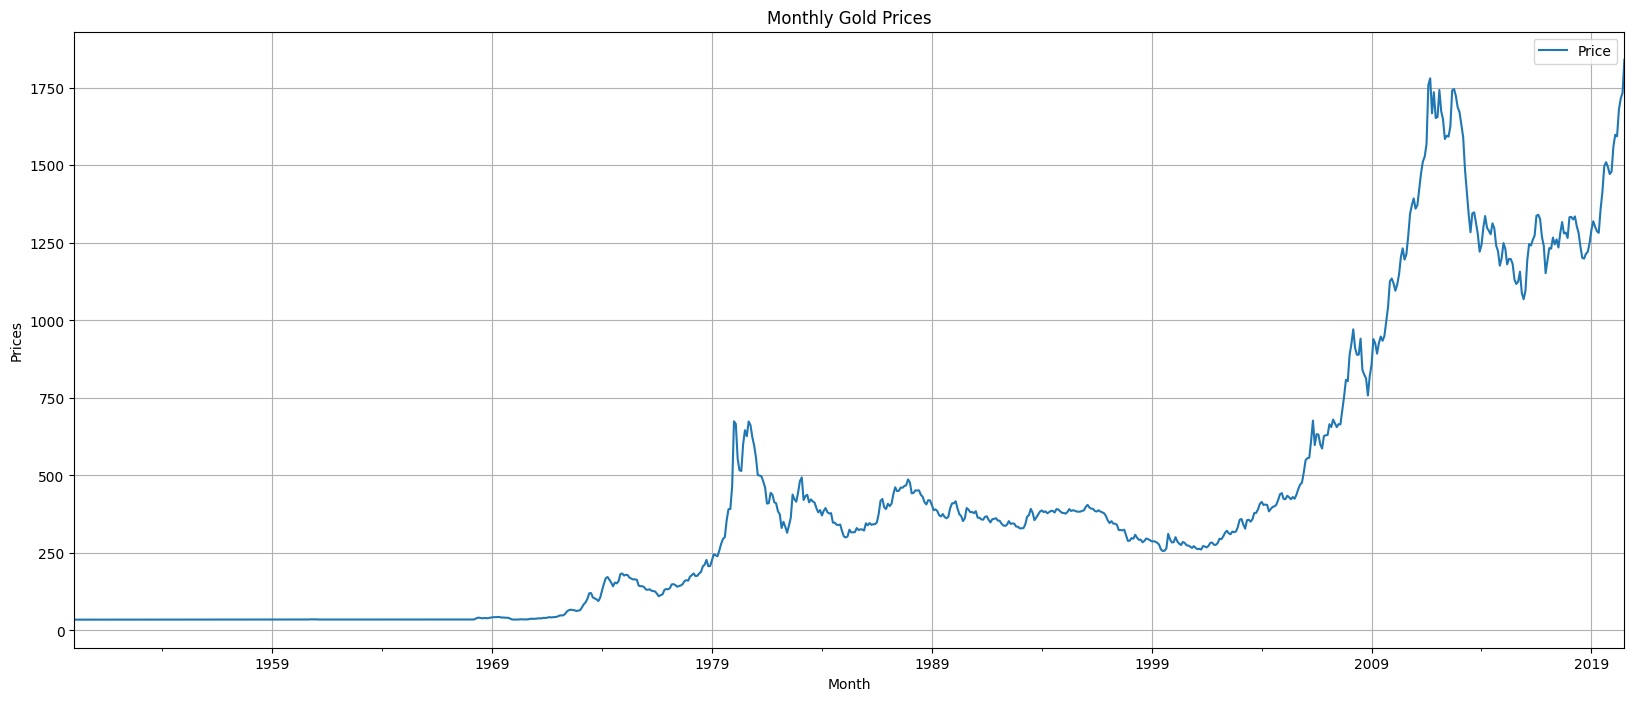

In [ ]:
ds.plot(figsize=(20,8))
plt.title("Monthly Gold Prices")
plt.xlabel("Month")
plt.ylabel("Prices")
plt.grid();

In [ ]:
round(ds.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


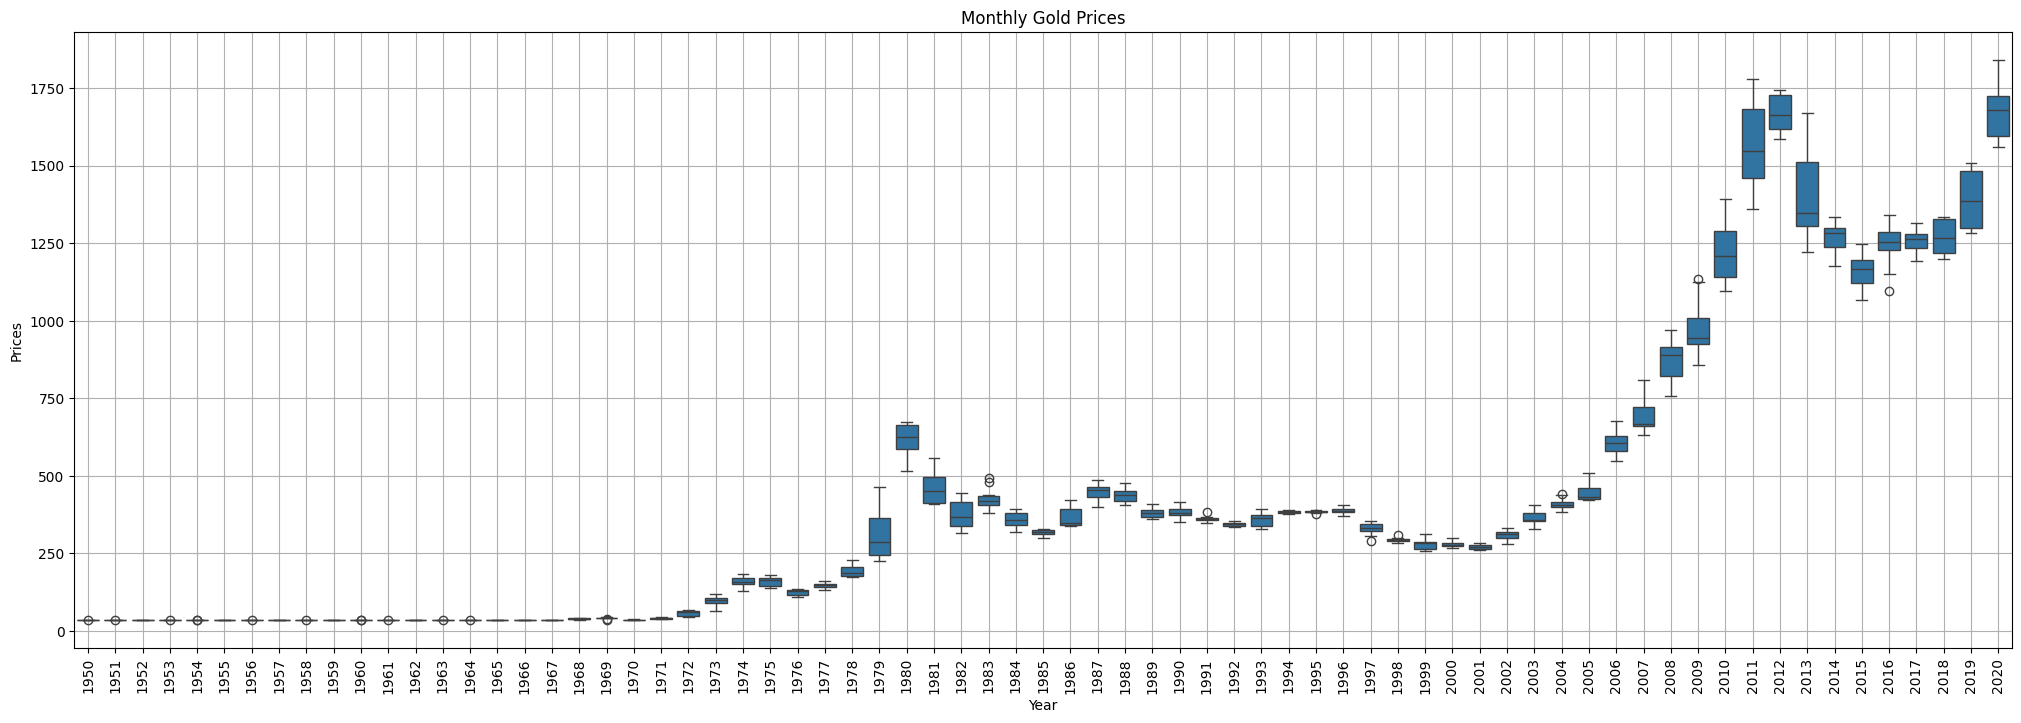

In [ ]:
_, ax=plt.subplots(figsize=(25,8))
sns.boxplot(x=ds.index.year, y=ds.values[:,0], ax=ax)
plt.title("Monthly Gold Prices")
plt.xlabel("Year")
plt.ylabel("Prices")
plt.xticks(rotation = 90)
plt.grid();



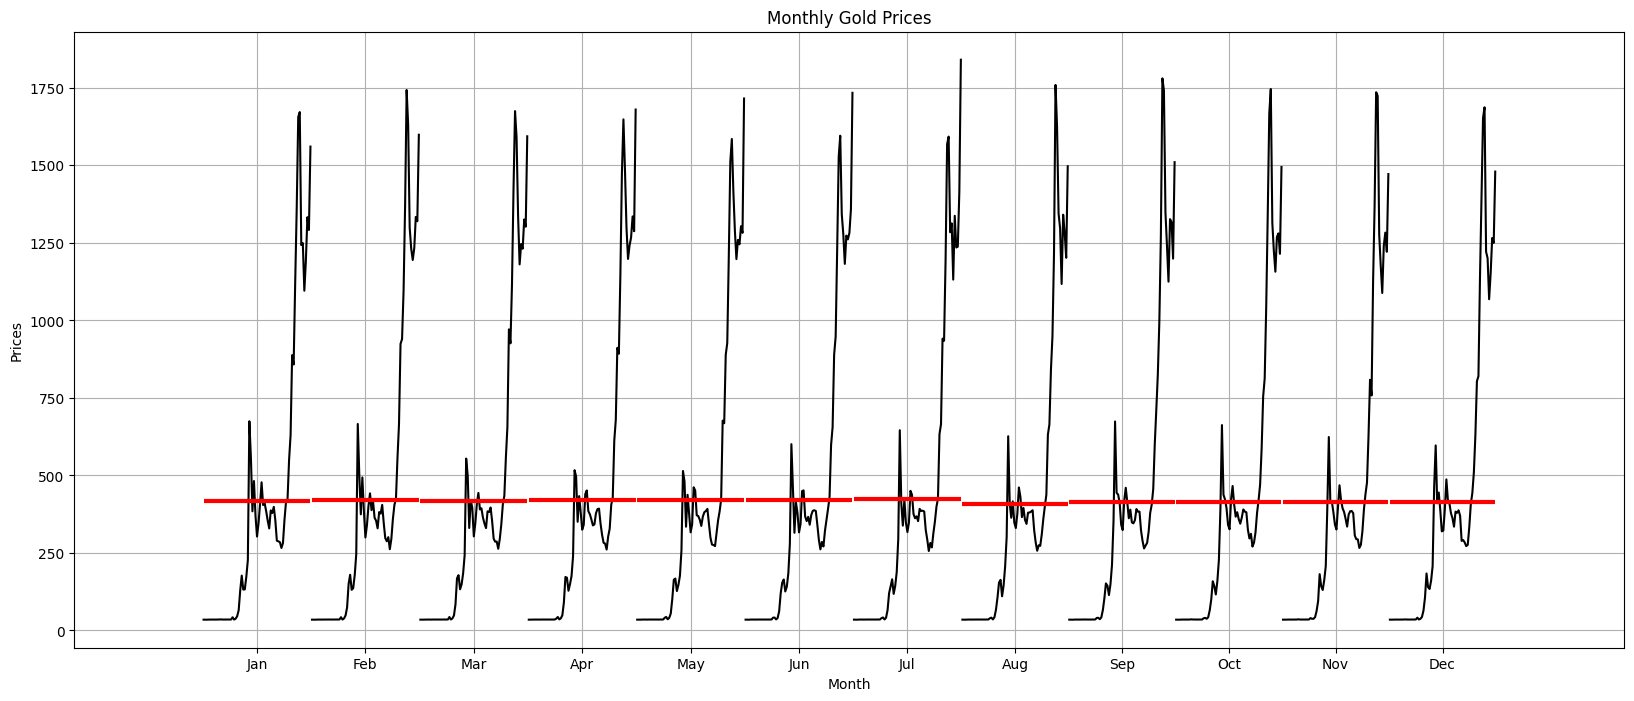

In [ ]:
from statsmodels.graphics.tsaplots import month_plot
fig, ax=plt.subplots(figsize=(20,8))
month_plot(ds,ylabel="Gold Prices", ax=ax)
plt.title("Monthly Gold Prices")
plt.xlabel("Month")
plt.ylabel("Prices")
plt.grid();


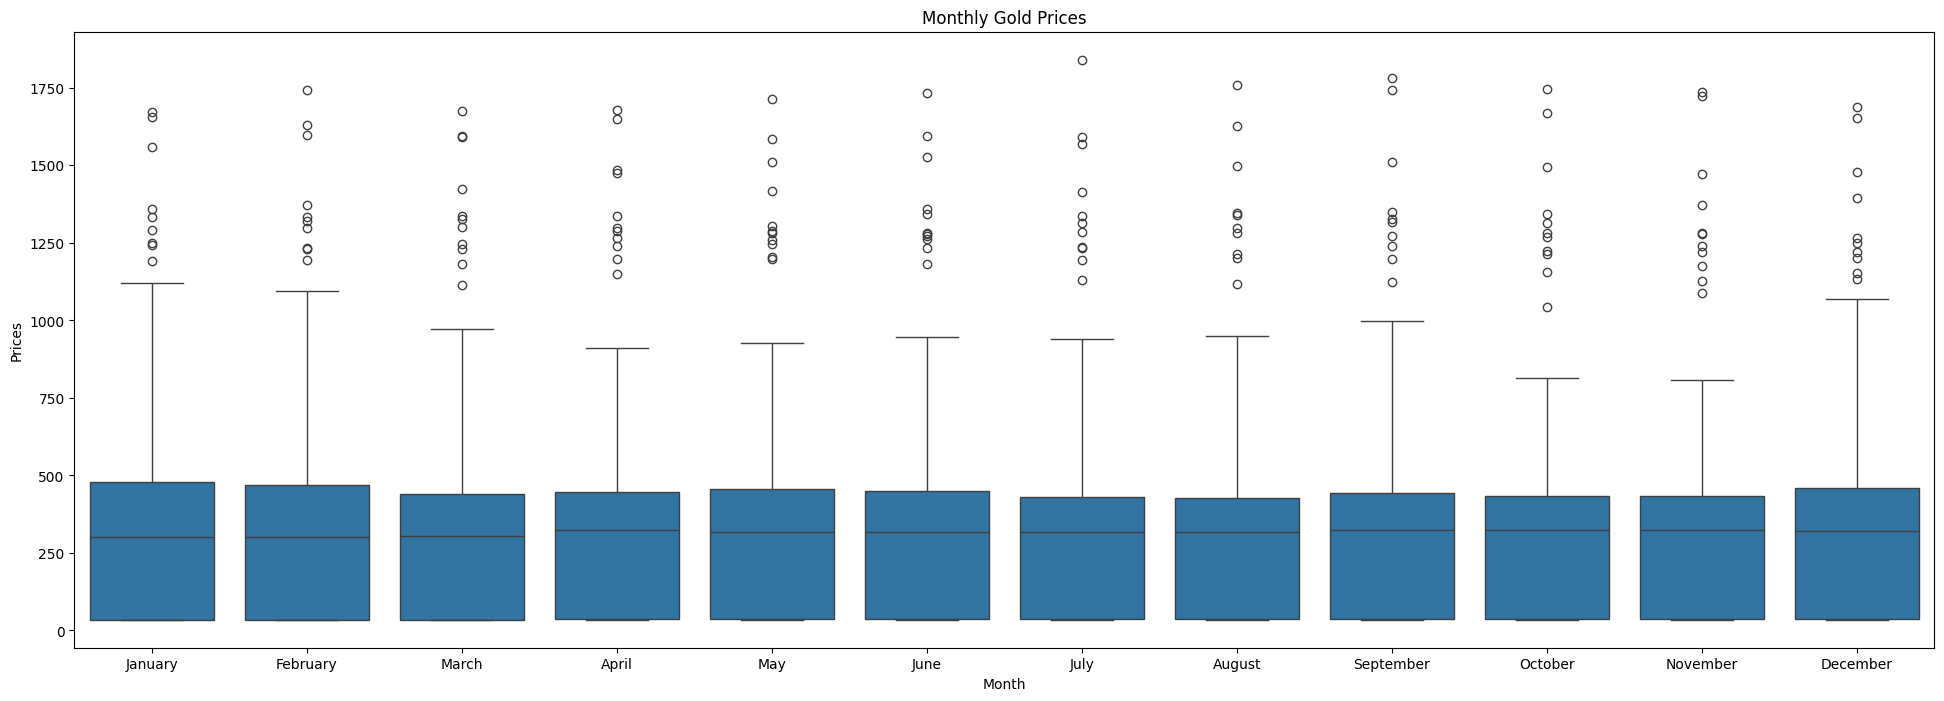

In [ ]:
_, ax=plt.subplots(figsize=(24,8))
sns.boxplot(x=ds.index.month_name(), y=ds.values[:,0], ax=ax)
plt.title("Monthly Gold Prices")
plt.xlabel("Month")
plt.ylabel("Prices")
plt.show()

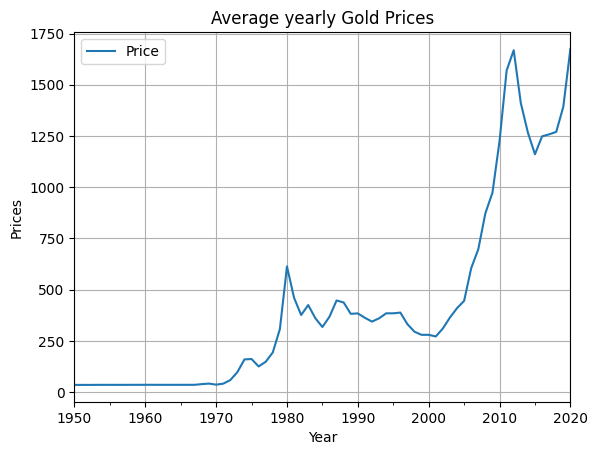

In [ ]:
ds_yearly_sum=ds.resample('A').mean()
ds_yearly_sum.plot();
plt.title("Average yearly Gold Prices")
plt.xlabel("Year")
plt.ylabel("Prices")
plt.grid();


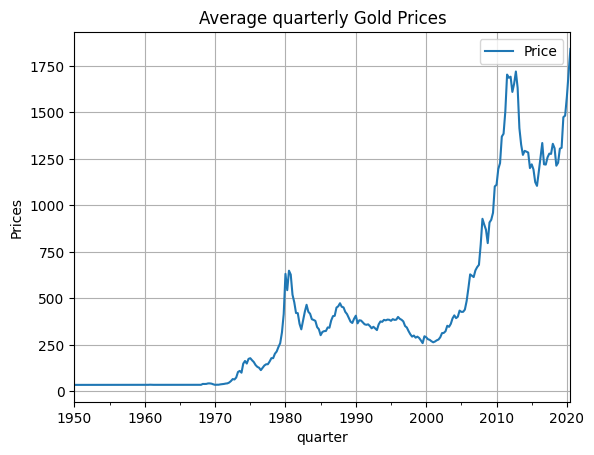

In [ ]:
ds_quarterly_sum=ds.resample('Q').mean()
ds_quarterly_sum.plot();
plt.title("Average quarterly Gold Prices")
plt.xlabel("quarter")
plt.ylabel("Prices")
plt.grid();


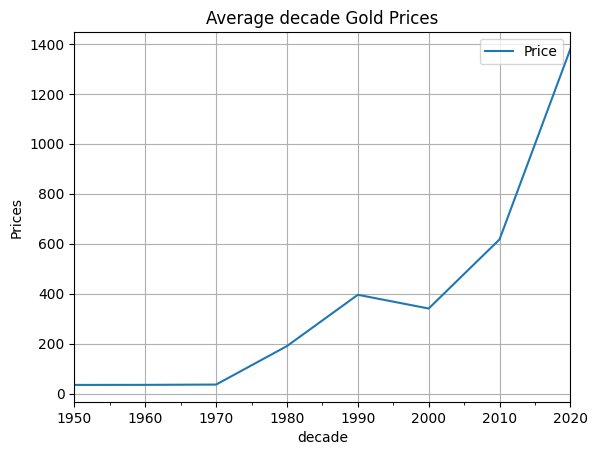

In [ ]:
ds_decade_sum=ds.resample('10y').mean()
ds_decade_sum.plot();
plt.title("Average decade Gold Prices")
plt.xlabel("decade")
plt.ylabel("Prices")
plt.grid();


In [ ]:
ds1=ds.groupby(ds.index.year).mean().rename(columns={'Price':"mean"})
ds1=ds1.merge(ds.groupby(ds.index.year).std().rename(columns={'Price':"std"}),left_index=True,right_index=True)
ds1['Cov_pct']=((ds1['std']/ds1['mean'])*100).round(2)
ds1.head()


,mean,std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


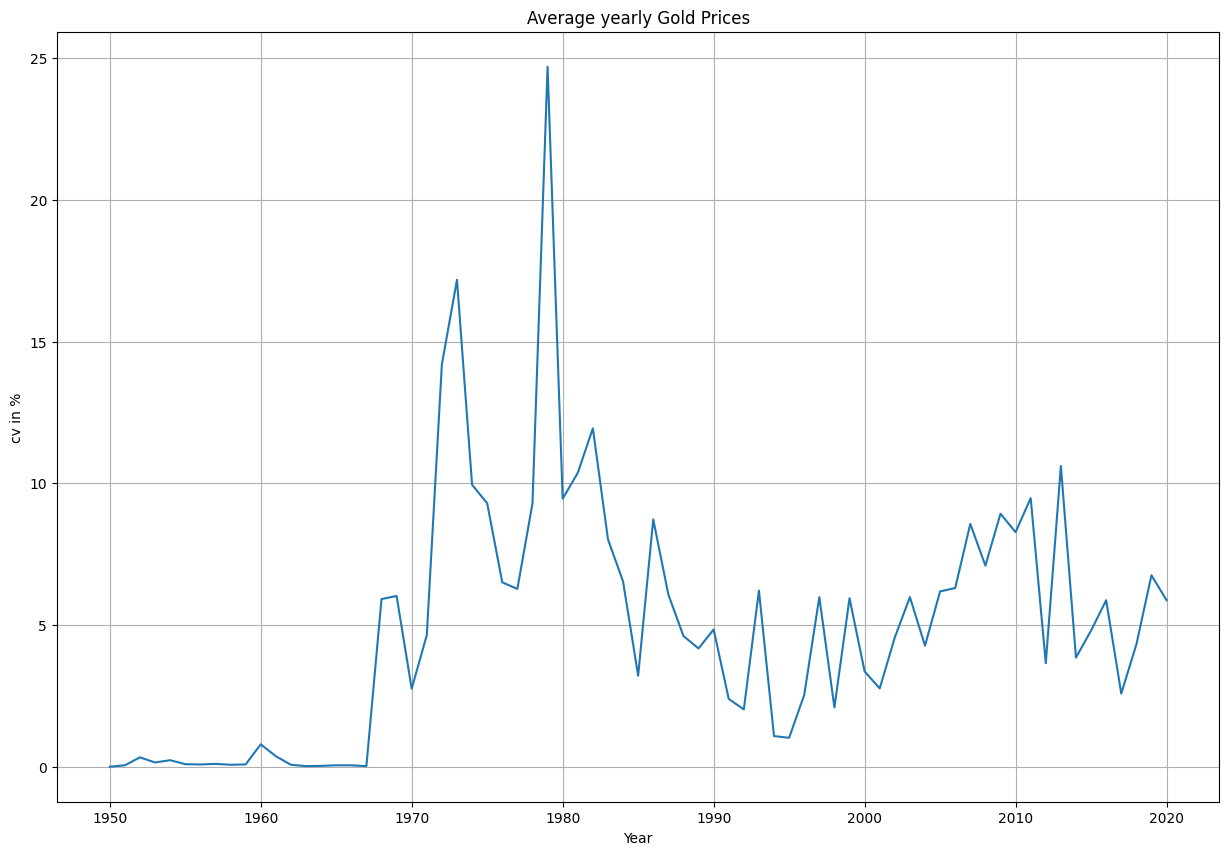

In [ ]:
fig,ax=plt.subplots(figsize=(15,10))
ds1['Cov_pct'].plot();
plt.title("Average yearly Gold Prices")
plt.xlabel("Year")
plt.ylabel("cv in %")
plt.grid();


In [ ]:
train=ds[ds.index.year<=2015]
test=ds[ds.index.year>2015]

In [ ]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


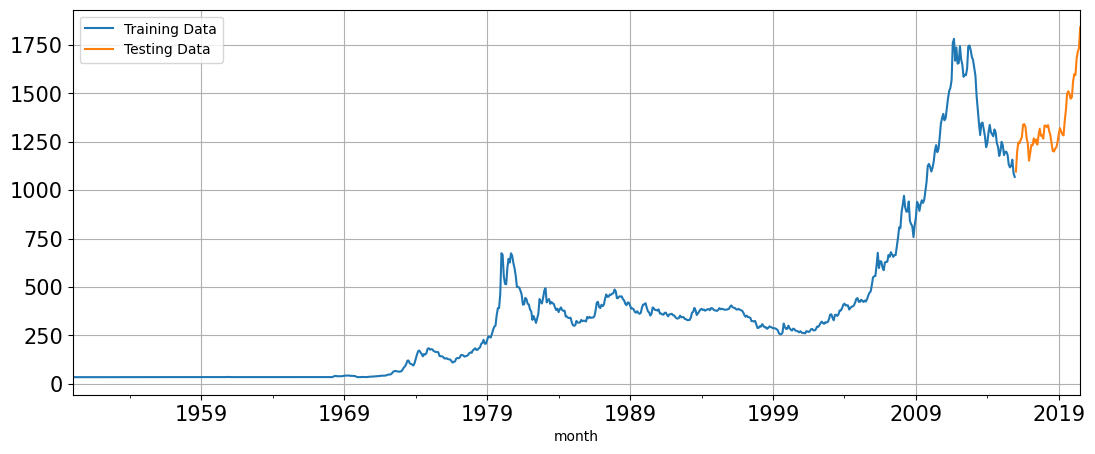

In [ ]:
train['Price'].plot(figsize=(13,5), fontsize=15)
test['Price'].plot(figsize=(13,5), fontsize=15)
plt.grid()
plt.legend(['Training Data','Testing Data'])
plt.show()

In [ ]:
tr_time=[i+1 for i in range(len(train))]
te_time=[i+len(train)+1 for i in range(len(test))]
len(tr_time),len(te_time)

(792, 55)

In [ ]:
LR_train=train.copy()
LR_test=test.copy()

In [ ]:
LR_train['time']=tr_time
LR_test['time']=te_time

In [ ]:
lr=LinearRegression()
lr.fit(LR_train[['time']],LR_train["Price"].values)

LinearRegression()

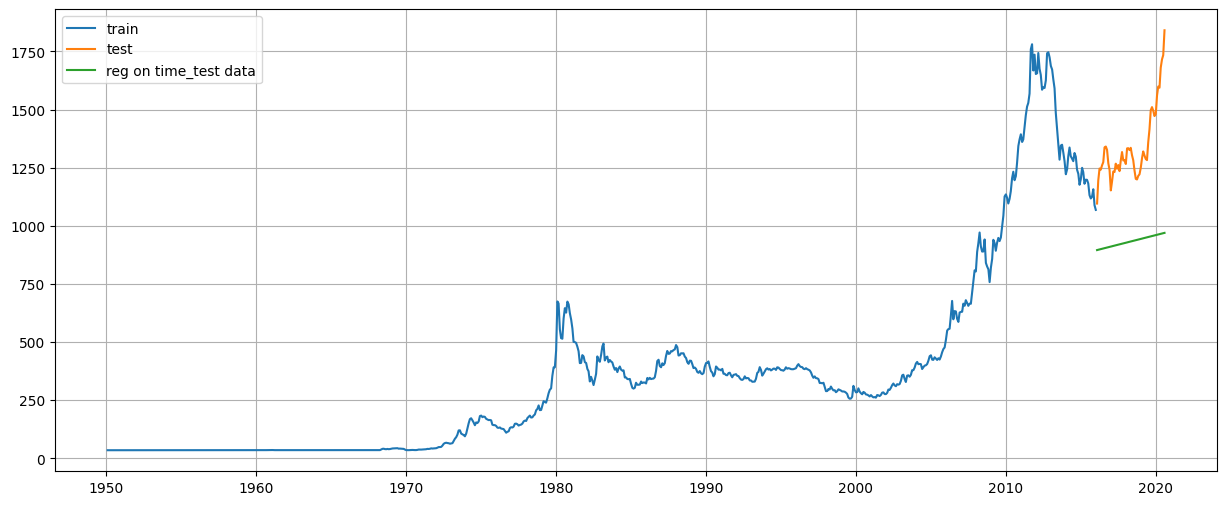

In [ ]:
test_predictions_model1=lr.predict(LR_test[['time']])
LR_test['forecast']=test_predictions_model1
plt.figure(figsize=(15,6))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'], label='reg on time_test data')
plt.legend(loc='best')
plt.grid()


In [ ]:
def mape(actual,pred):
  return round(np.mean(abs(actual-pred)/actual)*100,2)

In [ ]:
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print("MAPE is %3.3f" % (mape_model1_test), "%")

MAPE is 29.760 %


In [ ]:
result=pd.DataFrame({'Test mape (%)':[mape_model1_test]},index=['RegressionOnTime'])

In [ ]:
result

,Test mape (%)
RegressionOnTime,29.76


In [ ]:
Naive_train=train.copy()
Naive_test=test.copy()

In [ ]:
Naive_test['Naive']=np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['Naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: Naive, dtype: float64

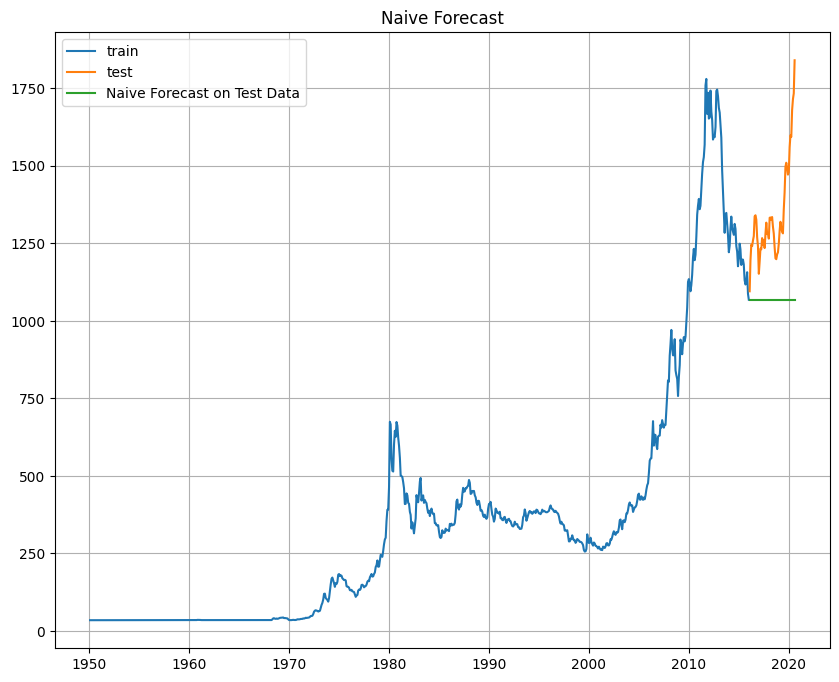

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(Naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(Naive_test['Naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()


In [ ]:
mape_model2_test = mape(test['Price'].values, Naive_test['Naive'].values)
print("For naive forecast on test data, MAPE is %3.3f" % (mape_model2_test), "%")

For naive forecast on test data, MAPE is 19.380 %


In [ ]:
Result=pd.DataFrame({'Test mape (%)':[mape_model2_test]},index=['Naivemodel'])
results=pd.concat([result,Result])
results

,Test mape (%)
RegressionOnTime,29.76
Naivemodel,19.38


In [ ]:
final_model=ExponentialSmoothing(ds,trend='additive', seasonal='additive').fit(
    smoothing_level=0.4,
    smoothing_trend=0.3,
    smoothing_seasonal=0.6)


In [ ]:
Mape_final_Model=mape(ds['Price'].values, final_model.fittedvalues)
print("Mape:", Mape_final_Model)

Mape: 17.24


In [ ]:
predictions=final_model.forecast(steps=len(test))

In [ ]:
pred_ds=pd.DataFrame({'lower_CI': predictions - 1.96*np.std(final_model.resid, ddof=1),
'prediction':predictions,
'upper_CI':predictions+1.96*np.std(final_model.resid, ddof=1)})
pred_ds.head()


,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


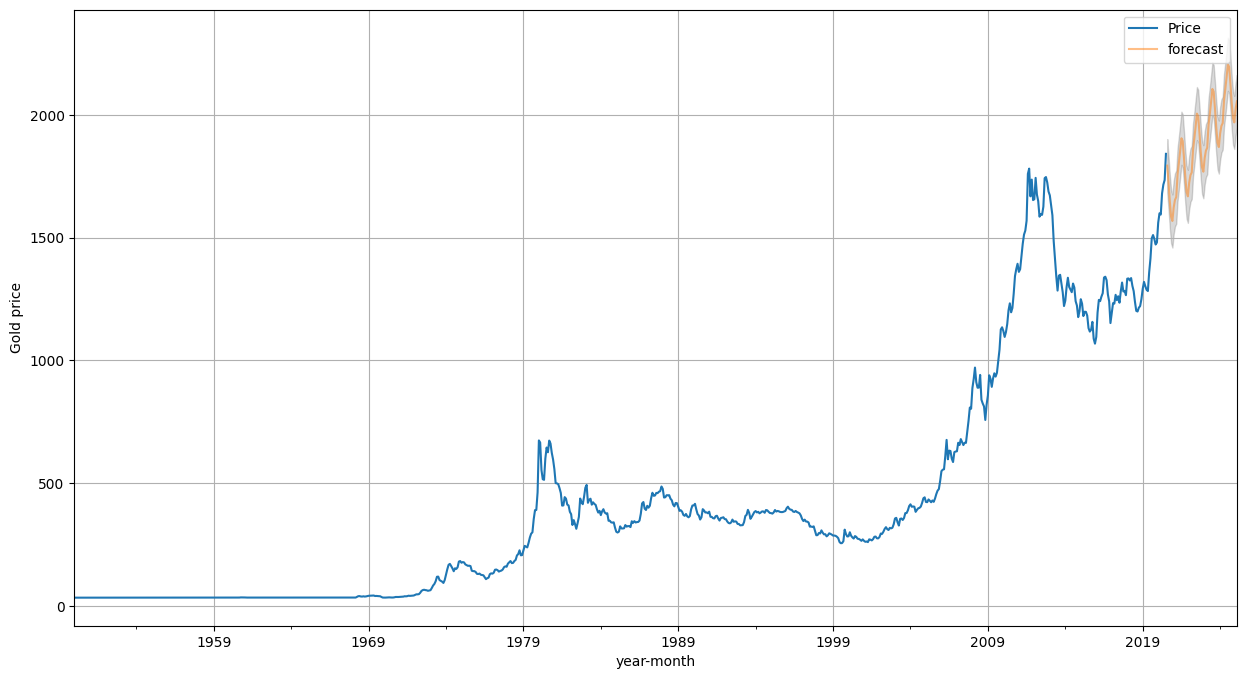

In [ ]:
axis=ds.plot(label='actual', figsize=(15,8))
pred_ds['prediction'].plot(ax=axis,label='forecast',alpha=0.5)
axis.fill_between(pred_ds.index, pred_ds['lower_CI'], pred_ds['upper_CI'], color='k', alpha=0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('Gold price')
plt.legend(loc='best')
plt.grid()
plt.show()